# import lib

In [1]:
%run EDA_common_utils.ipynb

In [11]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.inspection import plot_partial_dependence

# load data

In [3]:
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

# Preprocess

## AIRPORT_CODE and UNIQUE_CARRIER

In [4]:
def transform_object_cate_to_value_counts(df, col):
    values = df[col].value_counts().values
    condition_values = df[col].value_counts().index
    conditions = [df[col] == condition  for condition in condition_values]
    df[col] = np.select(conditions, values)
    
    return df

In [5]:
df_train = transform_object_cate_to_value_counts(df_train, 'UNIQUE_CARRIER')
df_train = transform_object_cate_to_value_counts(df_train, 'AIRPORT_CODE')

In [6]:
df_test = transform_object_cate_to_value_counts(df_test, 'UNIQUE_CARRIER')
df_test = transform_object_cate_to_value_counts(df_test, 'AIRPORT_CODE')

In [7]:
categorical_features = ['UNIQUE_CARRIER', 'AIRCRAFT_TYPE', 'AIRCRAFT_CONFIG_PASSENGER', 
                            'AIRPORT_CODE', 'SCHEDULED', 'DIRECTION_DEPART', 'LARGE_AIRPORT']

In [8]:
for col in categorical_features:
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

# Train model

In [9]:
df_train.columns

Index(['index', 'DEPARTURES_PERFORMED', 'PASSENGERS', 'FREIGHT', 'MAIL',
       'DISTANCE', 'AIR_TIME', 'UNIQUE_CARRIER', 'AIRCRAFT_TYPE',
       'AIRCRAFT_CONFIG_PASSENGER', 'YEAR', 'MONTH', 'GROUND_TIME',
       'AIRPORT_CODE', 'SCHEDULED', 'DIRECTION_DEPART', 'LARGE_AIRPORT'],
      dtype='object')

In [6]:
label = 'GROUND_TIME'

In [7]:
X_columns = [col for col in df_train.columns if col not in ['index', 'YEAR', label]]
X_train = df_train[X_columns]
X_test = df_test[X_columns]
y_train = df_train[label]
y_test = df_test[label]

In [8]:
X_train

DEPARTURES_PERFORMED  PASSENGERS     FREIGHT       MAIL     DISTANCE  \
0                      1.0   69.000000    0.000000   0.000000  1142.000000   
1                      1.0   66.000000    0.000000   0.000000  1142.000000   
2                      1.0   43.000000    0.000000   0.000000   399.000000   
3                      1.0  127.000000    0.000000   0.000000   735.000000   
4                      1.0  133.000000    0.000000   0.000000   735.000000   
...                    ...         ...         ...        ...          ...   
9681                 231.0   62.445887   63.346320  64.519481     1.727273   
9682                 231.0   26.922078    0.000000   0.000000     1.727273   
9683                 235.0   60.604255   60.817021  70.165957     1.697872   
9684                 238.0   33.848739  103.445378   0.000000     1.676471   
9685                 240.0   34.737500  128.575000   5.000000     1.662500   

        AIR_TIME  UNIQUE_CARRIER  AIRCRAFT_TYPE  AIRCRAFT_CONFIG_PASSENGER  \
0     151.000000             108            677                          1   
1     156.000000             108            677                          1   
2      56.000000             108            673                          1   
3      98.000000             356            699                          1   
4     100.000000             356            699                          1   
...          ...             ...            ...                        ...   
9681   66.303030             951            482                          1   
9682   59.575758            2531            673                          1   
9683   67.940426             951            482                          1   
9684   79.558824             951            482                          1   
9685   68.933333             951            482                          1   

      MONTH  AIRPORT_CODE  SCHEDULED  DIRECTION_DEPART  LARGE_AIRPORT  
0         4           383          1                 1              1  
1         4           383          1                 0              1  
2         4           799          1                 0              1  
3         5           486          1                 1              1  
4         5           486          1                 0              1  
...     ...           ...        ...               ...            ...  
9681      2           799          1                 0              1  
9682      3           799          1                 0              1  
9683      1           799          1                 0              1  
9684      9           799          1                 1              1  
9685      9           799          1                 0              1  

[9686 rows x 14 columns]

In [13]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['rmse'],
    'colsample_bytree': 0.3,
    'learning_rate': 0.01,
    'subsample': 0.7,
    'max_depth': 3,
    'min_child_samples': 100, 
    'min_child_weight': 0.001, 
    'min_split_gain': 0.01, 
    'n_estimators': 10000, 
    'n_jobs': 8, 
    'num_leaves': 31, 
    'subsample_freq': 50, 
    'seed': 2020, 
    'reg_alpha': 0.0, 
    'reg_lambda': 0.0, 
    'subsample_for_bin': 200000, 
    'categorical_features': ['UNIQUE_CARRIER', 'AIRCRAFT_TYPE', 'AIRCRAFT_CONFIG_PASSENGER', 
                            'AIRPORT_CODE', 'SCHEDULED', 'DIRECTION_DEPART', 'LARGE_AIRPORT']
}
lgbm_model = LGBMRegressor(**params)
lgbm_model.fit(X_train, y_train)

LGBMRegressor(categorical_features=['UNIQUE_CARRIER', 'AIRCRAFT_TYPE',
                                    'AIRCRAFT_CONFIG_PASSENGER', 'AIRPORT_CODE',
                                    'SCHEDULED', 'DIRECTION_DEPART',
                                    'LARGE_AIRPORT'],
              colsample_bytree=0.3, learning_rate=0.01, max_depth=3,
              metric=['rmse'], min_child_samples=100, min_split_gain=0.01,
              n_estimators=10000, n_jobs=8, objective='regression', seed=2020,
              subsample=0.7, subsample_freq=50)

In [14]:
y_test_pred = lgbm_model.predict(X_test)
rmse = mean_squared_error(y_test, y_test_pred) ** (1/2)
mae = mean_absolute_error(y_test, y_test_pred)
print(rmse)
print(mae)

7.208531329244203
4.4122489866935535


In [15]:
y_train_pred = lgbm_model.predict(X_train)
rmse = mean_squared_error(y_train, y_train_pred) ** (1/2)
mae = mean_absolute_error(y_train, y_train_pred)
print(rmse)
print(mae)

6.650283544095076
3.304628371521532


# Random forest

In [9]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model using the training data
rf_regressor.fit(X_train, y_train)

# Predict the target values for the testing data
y_pred = rf_regressor.predict(X_test)

# Calculate the mean squared error and R2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

TypeError: cannot unpack non-iterable PartialDependenceDisplay object

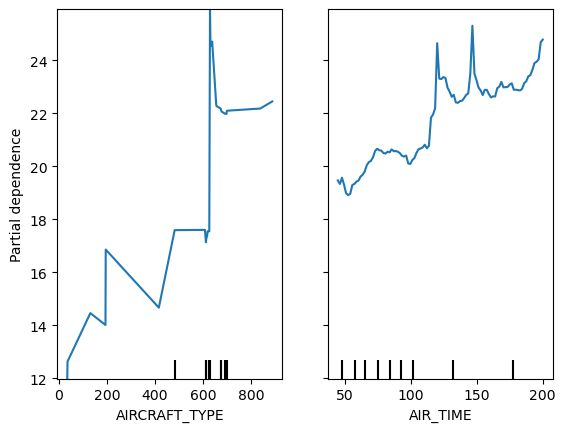

In [25]:
importance_scores = rf_regressor.feature_importances_
num_most_important = 2  # Replace with the desired number of most important predictors
most_important_indices = np.argsort(importance_scores)[-num_most_important:]

# Generate partial dependence plots for the most important predictors
fig, axs = plot_partial_dependence(rf_regressor, X_train, most_important_indices, feature_names=list(X_train.columns))  # Replace feature names

# Customize the plot
fig.suptitle('Partial Dependence Plots')
plt.subplots_adjust(top=0.9)

# Show the plot
plt.show()

In [41]:
importance_scores

array([2.30560429e-02, 1.06310847e-01, 6.22623485e-02, 1.68885394e-02,
       8.92994146e-02, 2.34270337e-01, 6.54073624e-02, 1.89535152e-01,
       1.19139431e-04, 8.14387985e-02, 4.62947559e-02, 6.33873403e-03,
       4.38336714e-02, 3.49448574e-02])

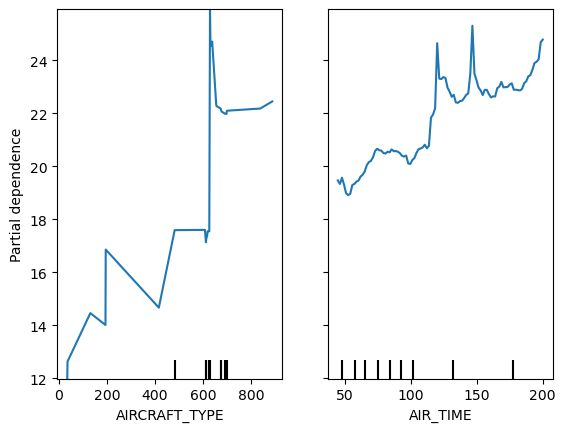

In [40]:
num_most_important = 2
most_important_indices = np.argsort(importance_scores)[-num_most_important:]
plot_partial_dependence(rf_regressor, X_train, most_important_indices)

In [26]:
importance_scores

array([2.30560429e-02, 1.06310847e-01, 6.22623485e-02, 1.68885394e-02,
       8.92994146e-02, 2.34270337e-01, 6.54073624e-02, 1.89535152e-01,
       1.19139431e-04, 8.14387985e-02, 4.62947559e-02, 6.33873403e-03,
       4.38336714e-02, 3.49448574e-02])

Feature ranking:
1. Feature 'AIR_TIME' (0.23427033684924262)
2. Feature 'AIRCRAFT_TYPE' (0.1895351518791879)
3. Feature 'PASSENGERS' (0.10631084668380536)
4. Feature 'DISTANCE' (0.08929941461662544)
5. Feature 'MONTH' (0.08143879850469864)
6. Feature 'UNIQUE_CARRIER' (0.06540736241121685)
7. Feature 'FREIGHT' (0.06226234853760448)
8. Feature 'AIRPORT_CODE' (0.046294755899512506)
9. Feature 'DIRECTION_DEPART' (0.043833671447603154)
10. Feature 'LARGE_AIRPORT' (0.03494485737989792)
11. Feature 'DEPARTURES_PERFORMED' (0.023056042906409866)
12. Feature 'MAIL' (0.016888539422242953)
13. Feature 'SCHEDULED' (0.006338734031389603)
14. Feature 'AIRCRAFT_CONFIG_PASSENGER' (0.00011913943056272181)


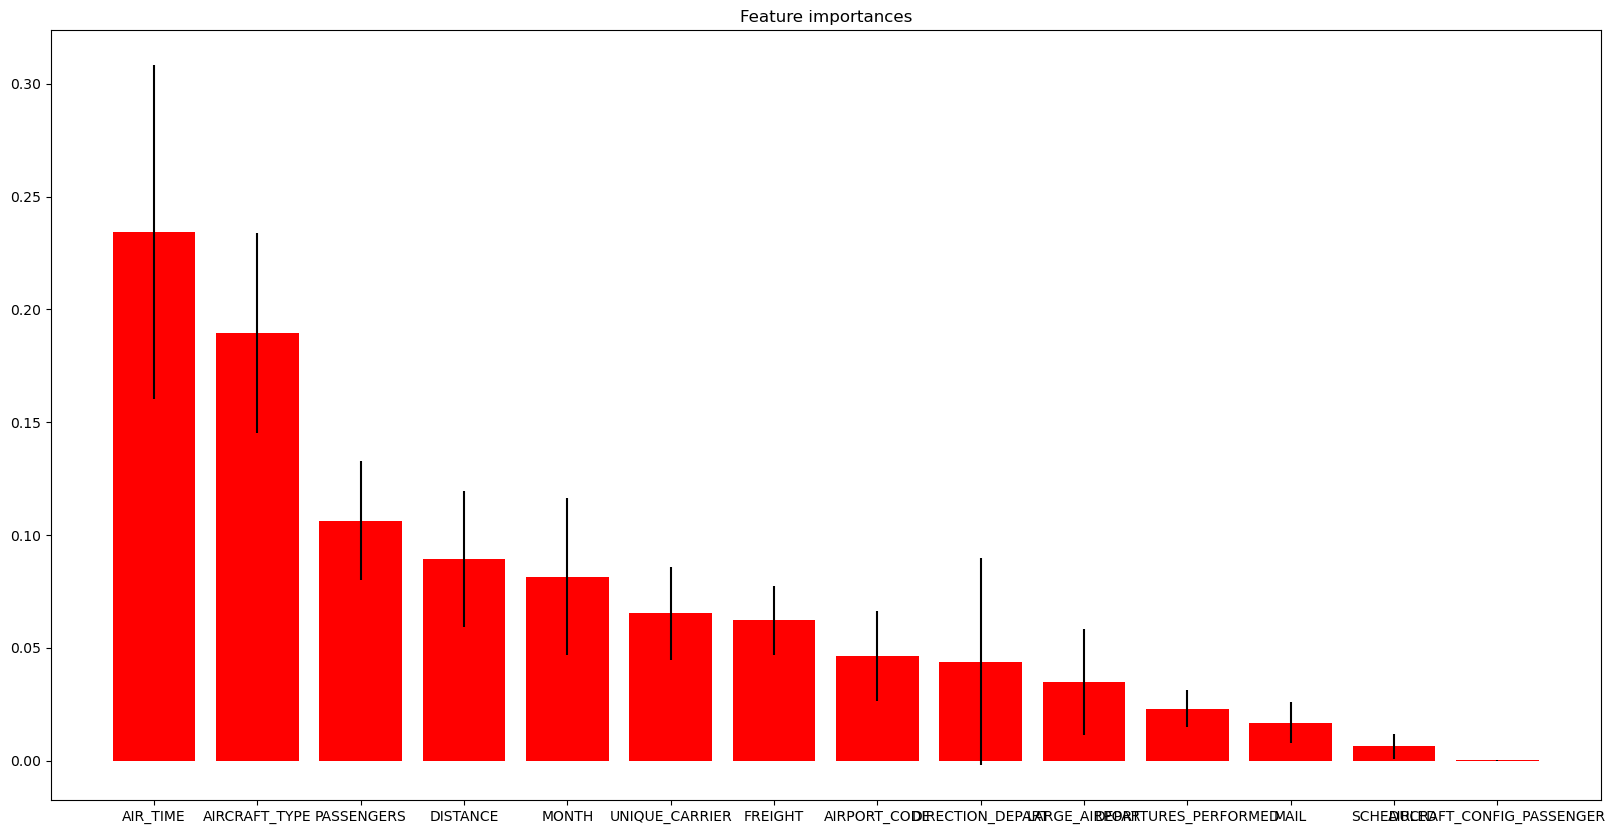

In [32]:
importances = rf_regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_regressor.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print feature importance ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. Feature '{X_columns[indices[f]]}' ({importances[indices[f]]})")

# Plot feature importance
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(X_columns)[indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [17]:
mse ** (1/2)

8.81632824685155

In [18]:
r2

-0.3686223638096544

In [91]:
y_pred

array([18.325798, 15.862957, 32.148605, ..., 20.072548, 19.528502,
       18.567532], dtype=float32)

In [103]:
# tmp = df_test
# tmp['x'] = y_pred
# test_data = pd.read_csv('test_data.csv')
# df_res = test_data.merge(tmp, on='index', how='left')['x'].fillna(0).reset_index()
# df_res.columns = ['id', 'x']
# df_res['id'] = df_res['id'] + 1
# df_res.to_csv('predicted_RF.csv', index=None)

# XGBoost

In [109]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Set the XGBoost hyperparameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'seed': 42
}

# Train the XGBoost model
num_rounds = 1000
early_stopping_rounds = 50
watchlist = [(dtest, 'test'), (dtrain, 'train')]

bst = xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)

# Make predictions on the test set
y_pred = bst.predict(dtest)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

[0]	test-rmse:19.76416	train-rmse:20.02084
[10]	test-rmse:9.20863	train-rmse:9.56525
[20]	test-rmse:7.23791	train-rmse:6.91516
[30]	test-rmse:7.05525	train-rmse:6.29837
[40]	test-rmse:7.08783	train-rmse:5.99157
[50]	test-rmse:7.13848	train-rmse:5.73164
[60]	test-rmse:7.20297	train-rmse:5.50104
[70]	test-rmse:7.20529	train-rmse:5.32414
[80]	test-rmse:7.23053	train-rmse:5.18793
[90]	test-rmse:7.22713	train-rmse:5.05699
[100]	test-rmse:7.25399	train-rmse:4.92579
[110]	test-rmse:7.31956	train-rmse:4.80905
[120]	test-rmse:7.33085	train-rmse:4.72616
[130]	test-rmse:7.34679	train-rmse:4.61919
[140]	test-rmse:7.37296	train-rmse:4.54591
[150]	test-rmse:7.39913	train-rmse:4.47545
[160]	test-rmse:7.42438	train-rmse:4.41110
[170]	test-rmse:7.44180	train-rmse:4.33369
[180]	test-rmse:7.47307	train-rmse:4.24997
[190]	test-rmse:7.48386	train-rmse:4.18083
[200]	test-rmse:7.48171	train-rmse:4.10946
[210]	test-rmse:7.48037	train-rmse:4.05244
[220]	test-rmse:7.49453	train-rmse:3.99733
[230]	test-rmse:7.51

In [110]:
mse ** (1/2)

7.899253583296123

In [111]:
tmp = df_test.copy()
tmp['x'] = y_pred
test_data = pd.read_csv('test_data.csv')
df_res = test_data.merge(tmp, on='index', how='left')['x'].fillna(0).reset_index()
df_res.columns = ['id', 'x']
df_res['id'] = df_res['id'] + 1
df_res.to_csv('predicted_XGBoost.csv', index=None)